In [31]:
import pandas as pd
import torch
import os
from matplotlib import pyplot as plt
from main import target_renamer, forecast_maker
from Models.lstm import LSTM

In [32]:
lags = 24
forecast_period=24
hidden_size = 100
num_layers = 4
dropout = 0.3
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [33]:
month_data = True #1 month of data for testing new code
month_range = pd.date_range("2018-08-01", "2018-08-31 23:00", freq='h', tz="UTC")
target_month = pd.date_range("2019-08-01", "2019-08-31 23:00", freq='h', tz="UTC")
eval_month = pd.date_range("2020-08-01", "2020-08-31 23:00", tz="UTC", freq='h')


# 0. Data initialization

In [34]:
openmeteo = pd.read_pickle("Data/openmeteo.pickle")

pvgis = pd.read_pickle('Data/PVGIS.pickle')
pvgis = pvgis.xs('P', axis=1)
pvgis = pvgis["2016-05-01":"2020-12-31"]
pvgis = pvgis.tz_localize("UTC")

CEDA = pd.read_pickle("CEDA_data.pickle")
CEDA_range = pd.date_range(CEDA.index.min()-pd.Timedelta('1h'), CEDA.index.max(), freq='h')
CEDA = CEDA.drop_duplicates(keep='first')
CEDA = CEDA.reindex(index=CEDA_range, method='nearest')

meteo2CEDA = {'temperature_2m' :'temperature_1_5m', 
              "relative_humidity_2m":"relative_humidity_1_5m", 
              "pressure_msl": "pressure_MSL",
              "cloud_cover":"total_cloud_amount",
              "shortwave_radiation_instant": "downward_surface_SW_flux",
              "diffuse_radiation_instant":"diffuse_surface_SW_flux",
              "direct_normal_irradiance_instant":"direct_surface_SW_flux",
              "wind_speed_10m": "wind_speed_10m",
              "wind_direction_10m": "wind_direction_10m"
              }
openmeteo = openmeteo.rename(columns=meteo2CEDA)
print(CEDA.info())


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 49704 entries, 2016-05-01 00:00:00+00:00 to 2021-12-31 23:00:00+00:00
Freq: h
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   temperature_1_5m          48971 non-null  float32
 1   relative_humidity_1_5m    48971 non-null  float32
 2   total_cloud_amount        48887 non-null  float32
 3   diffuse_surface_SW_flux   48803 non-null  float32
 4   direct_surface_SW_flux    48803 non-null  float32
 5   downward_surface_SW_flux  48971 non-null  float32
 6   pressure_MSL              48995 non-null  float32
 7   wind_speed_10m            48971 non-null  float32
 8   wind_direction_10m        48971 non-null  float32
dtypes: float32(9)
memory usage: 2.1 MB
None


In [35]:
installation_id = "3437BD60"
prodNL = pd.read_parquet('Data/production.parquet', engine='pyarrow')
metadata = pd.read_csv("Data/installations Netherlands.csv", sep=';')
metadata = metadata.set_index('id')
metadata_id = metadata.loc[installation_id]
tilt = metadata_id["Tilt"]
peakPower = metadata_id["Watt Peak"]
azimuth = metadata_id["Orientation"]
latitude = metadata_id["Latitude"]
longitude = metadata_id["Longitude"]
power = prodNL.loc[installation_id]
power = target_renamer(power, 'watt')
power = power.resample('h').sum()/4
power = power.tz_localize('UTC')

print(openmeteo['wind_direction_10m'])


date
2016-05-01 00:00:00+00:00      6.008918
2016-05-01 01:00:00+00:00      2.935620
2016-05-01 02:00:00+00:00      1.397161
2016-05-01 03:00:00+00:00    360.000000
2016-05-01 04:00:00+00:00      1.548122
                                ...    
2020-08-31 19:00:00+00:00      7.594560
2020-08-31 20:00:00+00:00      7.765082
2020-08-31 21:00:00+00:00      8.130019
2020-08-31 22:00:00+00:00     15.068549
2020-08-31 23:00:00+00:00     18.435053
Name: wind_direction_10m, Length: 38016, dtype: float32


# 1. Historic weather 

Case study 1:
|   | Source   | Target |
|---|----------|--------|
| X |open-meteo| CEDA|
| Y | PVGIS    | Prod NL|

In [36]:
target_CEDA = CEDA[CEDA.index.isin(target_month)]
target_power = power[power.index.isin(target_month)]
eval_CEDA = CEDA[CEDA.index.isin(eval_month)]
eval_power = power[power.index.isin(eval_month)]
eval_power.head()

,P
timestamp,
2020-08-01 00:00:00+00:00,0.0
2020-08-01 01:00:00+00:00,0.0
2020-08-01 02:00:00+00:00,0.0
2020-08-01 03:00:00+00:00,0.0
2020-08-01 04:00:00+00:00,7.0


In [37]:
from Data.Featurisation import Featurisation
# SOURCE DATA
data = pd.merge(pvgis, openmeteo, left_index=True, right_index=True)

data = [data] # Put it in a list to work with featurisation object

#2. Featurise data & ready for training & testing 7
data = Featurisation(data)
data.data = data.cyclic_features()
data.data = data.add_shift('P')
data.data = data.cyclic_angle('wind_direction_10m')



source_dataset = data.data[0]
if month_data:
    source_dataset = source_dataset[source_dataset.index.isin(month_range)]


#TARGET DATASET
target_dataset = pd.merge(target_power, target_CEDA, left_index=True, right_index=True, how='inner')
data = [target_dataset] # Put it in a list to work with featurisation object

#2. Featurise data & ready for training & testing 7
data = Featurisation(data)
data.data = data.cyclic_features()
data.data = data.add_shift('P')
data.data = data.cyclic_angle('wind_direction_10m')

target_dataset = data.data[0]
target_dataset = target_dataset.reindex(index=pd.Index(target_month), method='nearest')

## EVALUATION DATASET
eval_dataset = pd.merge(eval_power, eval_CEDA, left_index=True, right_index=True, how='inner')
data = [eval_dataset] # Put it in a list to work with featurisation object

#2. Featurise data & ready for training & testing 7
data = Featurisation(data)
data.data = data.cyclic_features()
data.data = data.add_shift('P')
data.data = data.cyclic_angle('wind_direction_10m')

eval_dataset = data.data[0]
eval_dataset = eval_dataset.reindex(index=pd.Index(eval_month), method='nearest')


In [38]:
# P = source_dataset['P']
# P_24h= source_dataset["P_24h_shift"]
# daterange = pd.date_range("2018-07-02", "2018-07-06", freq='h', tz="UTC")
# plt.figure()
# plt.plot(daterange, P[daterange],color="#11aa00", label="Actual power")
# plt.plot(daterange, P_24h[daterange], color="#11aa0055", label="Power 24h shifted")
# plt.legend()

In [39]:
tuning_method = 'whole'
source_features = list(source_dataset.columns)
print(source_features)


['P', 'temperature_1_5m', 'relative_humidity_1_5m', 'pressure_MSL', 'total_cloud_amount', 'downward_surface_SW_flux', 'diffuse_surface_SW_flux', 'direct_surface_SW_flux', 'wind_speed_10m', 'wind_direction_10m', 'hour_sin', 'hour_cos', 'month_sin', 'month_cos', 'P_24h_shift', 'wind_direction_10m_cos', 'wind_direction_10m_sin']


c:\Users\Robbe\PycharmProjects\SolNet 2\tensors\Tensorisation.py:102: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  X_tensor = torch.tensor(self.data[feature]).type(torch.float32)


c:\Users\Robbe\PycharmProjects\SolNet 2\tensors\Tensorisation.py:122: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y_tensor = torch.tensor(self.data['P']).type(torch.float32)


Shape of data:  torch.Size([24, 24, 16]) torch.Size([6, 24, 16]) torch.Size([24, 24, 1]) torch.Size([6, 24, 1])
LSTM(
  (lstm): LSTM(16, 100, num_layers=4, batch_first=True, dropout=0.3)
  (linear): Linear(in_features=100, out_features=24, bias=True)
)
Step 0: Average train loss: 0.1343 | Average test loss: 0.0964
Step 5: Average train loss: 0.0999 | Average test loss: 0.0633
Step 10: Average train loss: 0.0360 | Average test loss: 0.0483
Step 15: Average train loss: 0.0215 | Average test loss: 0.0193
Step 20: Average train loss: 0.0228 | Average test loss: 0.0210
Step 25: Average train loss: 0.0204 | Average test loss: 0.0237
Step 30: Average train loss: 0.0184 | Average test loss: 0.0191
Step 35: Average train loss: 0.0181 | Average test loss: 0.0182
Step 40: Average train loss: 0.0166 | Average test loss: 0.0180
Step 45: Average train loss: 0.0126 | Average test loss: 0.0146
Step 50: Average train loss: 0.0095 | Average test loss: 0.0173
Step 55: Average train loss: 0.0085 | Average

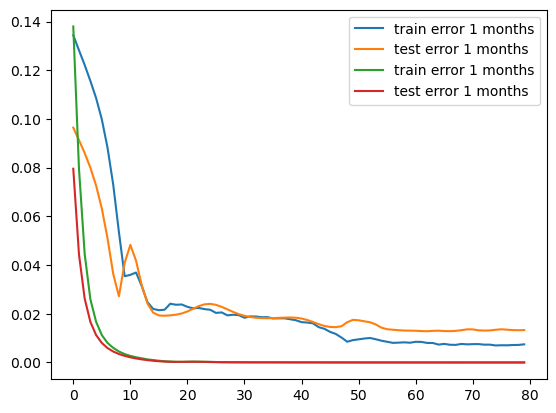

In [40]:
source_state_dict, target_state_dict = forecast_maker(source_dataset, target_dataset, tuning_method, source_features)

In [41]:
#Check data leakage (not robust lol)
input_weights = [0]*14
for i in range(0,14):
    input_weights[i] = abs(target_state_dict['lstm.weight_ih_l0'][i]).sum()
print(input_weights)

[tensor(0.8239), tensor(0.7620), tensor(0.9720), tensor(0.9201), tensor(0.8600), tensor(0.9053), tensor(0.6384), tensor(0.8433), tensor(0.9083), tensor(0.9799), tensor(0.7294), tensor(0.7833), tensor(0.8367), tensor(0.8575)]


In [42]:
input_size = len(source_features)-1
fit_model = LSTM(input_size,hidden_size,num_layers, forecast_period, dropout).to(device)
fit_model.load_state_dict(target_state_dict)
predict_day = pd.date_range("2022-08-01", "2022-08-01 23:00", freq='h', tz='UTC')
X = CEDA[CEDA.index.isin(predict_day)]
fit_model()

RuntimeError: Error(s) in loading state_dict for LSTM:
	size mismatch for lstm.weight_ih_l0: copying a param with shape torch.Size([400, 16]) from checkpoint, the shape in current model is torch.Size([400, 15]).

# 2. NWP data

Case study 1:
|   | Source   | Target |
|---|----------|--------|
| X | CEDA | CEDA|
| Y | PVGIS    | Prod NL|

In [ ]:

target_CEDA = CEDA[CEDA.index.isin(target_month)]
target_power = power[power.index.isin(target_month)]
target_power.head()


,P
timestamp,
2019-08-01 00:00:00+00:00,0.0
2019-08-01 01:00:00+00:00,0.0
2019-08-01 02:00:00+00:00,0.0
2019-08-01 03:00:00+00:00,0.0
2019-08-01 04:00:00+00:00,7.0


In [ ]:
from Data.Featurisation import Featurisation

data = pd.merge(pvgis, CEDA, left_index=True, right_index=True)

data = [data] # Put it in a list to work with featurisation object

#2. Featurise data & ready for training & testing 7
data = Featurisation(data)
data.data = data.cyclic_features()
data.data = data.add_shift('P')


source_dataset = data.data[0]
if month_data:
    source_dataset = source_dataset[source_dataset.index.isin(month_range)]

target_dataset = pd.merge(target_power, target_CEDA, left_index=True, right_index=True, how='inner')
data = [target_dataset] # Put it in a list to work with featurisation object

#2. Featurise data & ready for training & testing 7
data = Featurisation(data)
data.data = data.cyclic_features()
data.data = data.add_shift('P')

target_dataset = data.data[0]
print(source_dataset)

                             P  temperature_1_5m  relative_humidity_1_5m  \
2018-08-01 00:00:00+00:00  0.0        292.435059               65.144501   
2018-08-01 01:00:00+00:00  0.0        292.435059               65.144501   
2018-08-01 02:00:00+00:00  0.0        292.435059               65.144501   
2018-08-01 03:00:00+00:00  0.0        292.435059               65.144501   
2018-08-01 04:00:00+00:00  0.0        292.435059               65.144501   
...                        ...               ...                     ...   
2018-08-31 19:00:00+00:00  0.0        287.423096               75.732742   
2018-08-31 20:00:00+00:00  0.0        286.219971               78.033867   
2018-08-31 21:00:00+00:00  0.0        285.416016               76.860329   
2018-08-31 22:00:00+00:00  0.0        284.307617               81.826218   
2018-08-31 23:00:00+00:00  0.0        283.846680               84.743080   

                           total_cloud_amount  diffuse_surface_SW_flux  \
2018-08-01 00

In [ ]:
tuning_method = 'whole'
source_features = list(source_dataset.columns)
print(source_features)

['P', 'temperature_1_5m', 'relative_humidity_1_5m', 'total_cloud_amount', 'diffuse_surface_SW_flux', 'direct_surface_SW_flux', 'downward_surface_SW_flux', 'pressure_MSL', 'wind_speed_10m', 'wind_direction_10m', 'hour_sin', 'hour_cos', 'month_sin', 'month_cos', 'P_24h_shift']


c:\Users\Robbe\PycharmProjects\SolNet 2\tensors\Tensorisation.py:102: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  X_tensor = torch.tensor(self.data[feature]).type(torch.float32)


c:\Users\Robbe\PycharmProjects\SolNet 2\tensors\Tensorisation.py:122: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y_tensor = torch.tensor(self.data['P']).type(torch.float32)


Shape of data:  torch.Size([24, 24, 14]) torch.Size([6, 24, 14]) torch.Size([24, 24, 1]) torch.Size([6, 24, 1])
LSTM(
  (lstm): LSTM(14, 100, num_layers=4, batch_first=True, dropout=0.3)
  (linear): Linear(in_features=100, out_features=24, bias=True)
)
Step 0: Average train loss: 0.1365 | Average test loss: 0.0951
Step 5: Average train loss: 0.0939 | Average test loss: 0.0539
Step 10: Average train loss: 0.0428 | Average test loss: 0.0405
Step 15: Average train loss: 0.0233 | Average test loss: 0.0186
Step 20: Average train loss: 0.0220 | Average test loss: 0.0248
Step 25: Average train loss: 0.0198 | Average test loss: 0.0217
Step 30: Average train loss: 0.0197 | Average test loss: 0.0187
Step 35: Average train loss: 0.0181 | Average test loss: 0.0201
Step 40: Average train loss: 0.0182 | Average test loss: 0.0184
Step 45: Average train loss: 0.0159 | Average test loss: 0.0161
Step 50: Average train loss: 0.0120 | Average test loss: 0.0138
Step 55: Average train loss: 0.0112 | Average

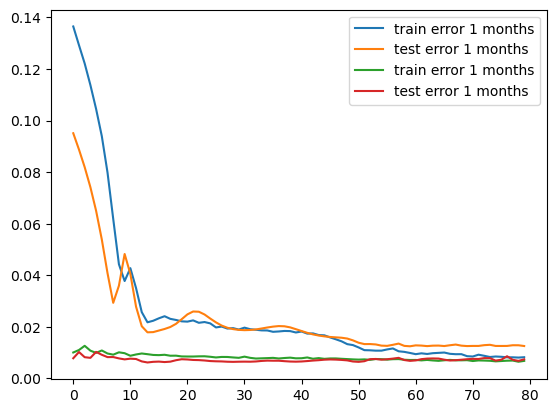

In [ ]:
source_state_dict, target_state_dict = forecast_maker(source_dataset, target_dataset, tuning_method, source_features)